# Brain Tumor Detection Using a Convolutional Neural Network

## Import Necessary Modules

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense,Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

%matplotlib inline

## Data Preparation & Preprocessing

In [8]:
def crop_brain_contour(image, plot=False):
    
    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Apply Contrast limited Adaptive histogram equalization to improve contrast
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray = clahe.apply(gray)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    #Closing performed more number of operations
    thresh = cv2.erode(thresh, None, iterations=6)
    thresh = cv2.dilate(thresh, None, iterations=6)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

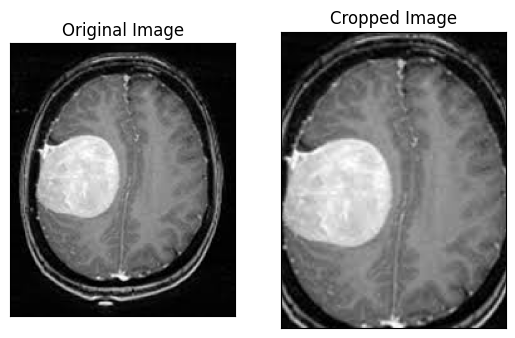

In [9]:
ex_img = cv2.imread('yes/Y1.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

### Load up the data:

In [10]:
def load_data(dir_list, image_size):
    """
    Read images, resize and normalize them. 
    Arguments:
        dir_list: list of strings representing file directories.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            image = cv2.imread(directory + '/' + filename)
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [11]:
augmented_path = 'augmented data/'

# augmented data (yes and no) contains both the original and the new generated examples
augmented_yes = augmented_path + 'yes' 
augmented_no = augmented_path + 'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 2065
X shape is: (2065, 240, 240, 3)
y shape is: (2065, 1)


### Plot sample images:

In [12]:
def plot_sample_images(X, y, n=50):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """
    
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

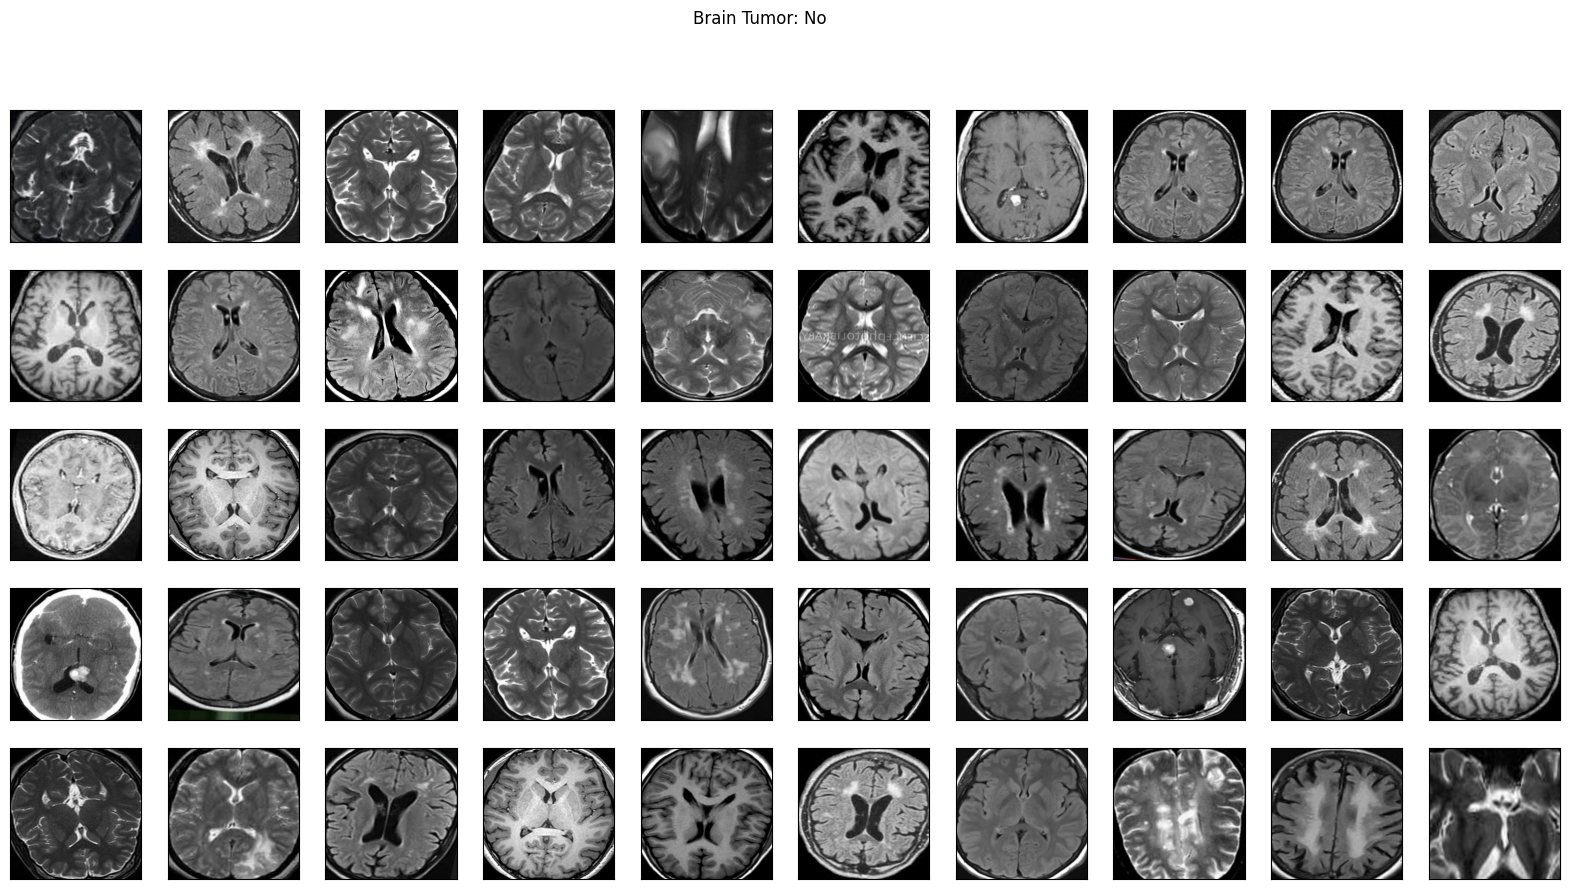

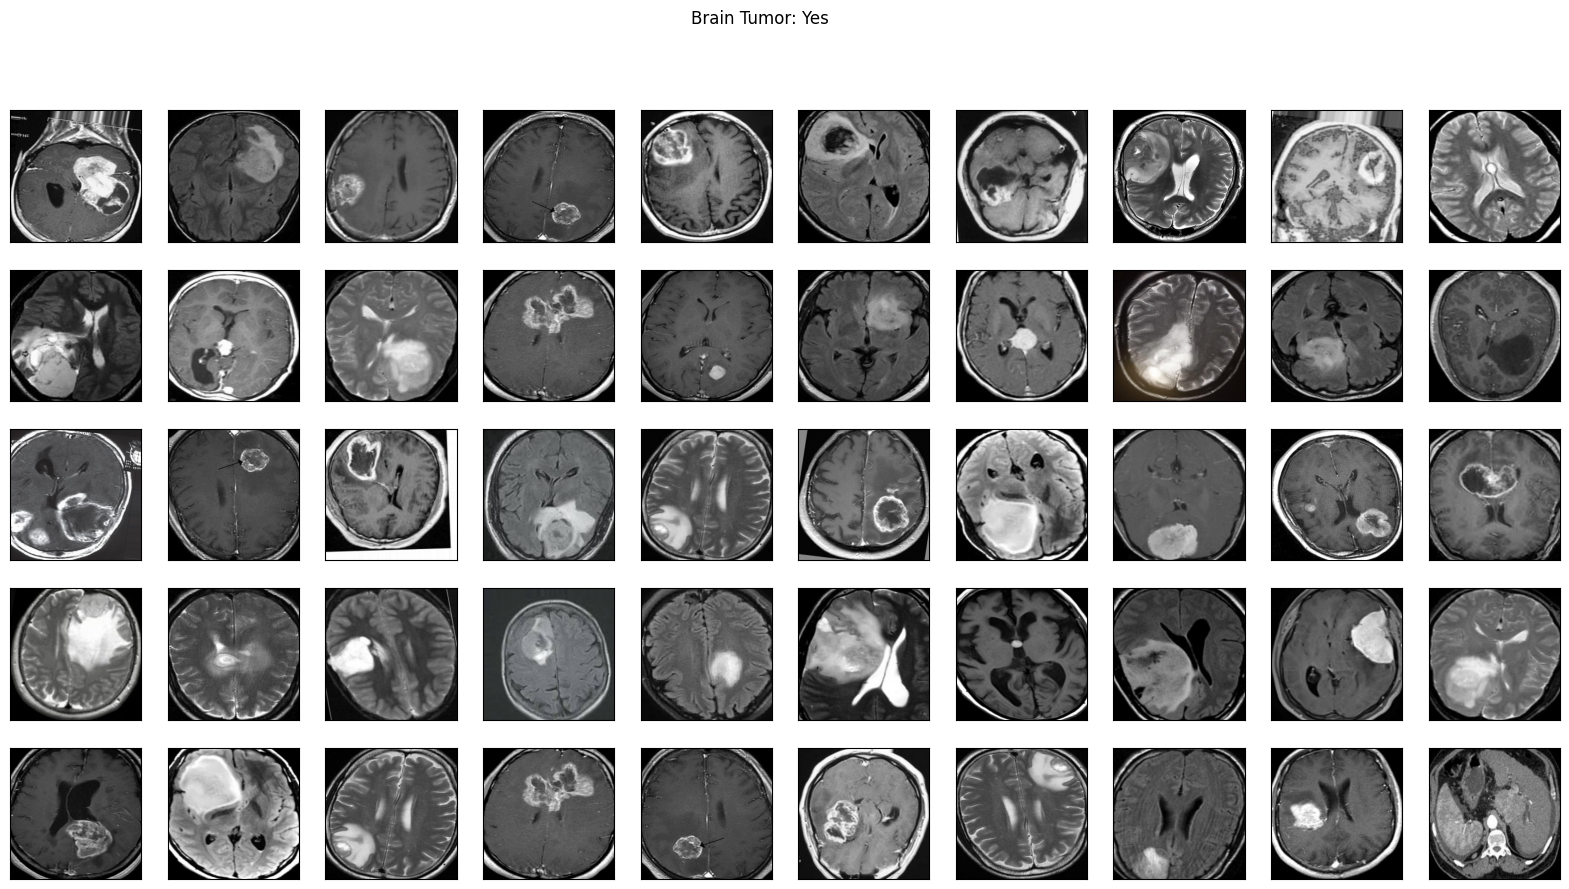

In [13]:
plot_sample_images(X, y)

In [14]:
def split_data(X, y, test_size=0.2):
       
    """
    Splits data into training, development and test sets.
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    Returns:
        X_train: A numpy array with shape = (#_train_examples, image_width, image_height, #_channels)
        y_train: A numpy array with shape = (#_train_examples, 1)
        X_val: A numpy array with shape = (#_val_examples, image_width, image_height, #_channels)
        y_val: A numpy array with shape = (#_val_examples, 1)
        X_test: A numpy array with shape = (#_test_examples, image_width, image_height, #_channels)
        y_test: A numpy array with shape = (#_test_examples, 1)
    """
    
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [15]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [16]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 1445
number of development examples = 310
number of test examples = 310
X_train shape: (1445, 240, 240, 3)
Y_train shape: (1445, 1)
X_val (dev) shape: (310, 240, 240, 3)
Y_val (dev) shape: (310, 1)
X_test shape: (310, 240, 240, 3)
Y_test shape: (310, 1)


Some helper functions:

In [17]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [18]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

# Build the model

Let's build a convolutional neural network model:

<img src='convnet_architecture.jpg'>

In [19]:
# def build_model(input_shape):
#     """
#     Arugments:
#         input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
#     Returns:
#         model: A Model object.
#     """
#     # Define the input placeholder as a tensor with shape input_shape. 
#     X_input = Input(input_shape) # shape=(?, 240, 240, 3)
    
#     # Zero-Padding: pads the border of X_input with zeroes
#     X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)
    
#     # CONV -> BN -> RELU Block applied to X
#     X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
#     X = BatchNormalization(axis = 3, name = 'bn0')(X)
#     X = Activation('relu')(X) # shape=(?, 238, 238, 32)
    
#     # MAXPOOL
#     X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32) 
    
#     # MAXPOOL
#     X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)
    
#     # FLATTEN X 
#     X = Flatten()(X) # shape=(?, 6272)
#     # FULLYCONNECTED
#     X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)

def build_model(input_shape):
    """
    Arugments:
        input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
    Returns:
        model: A Model object.
    """
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)
    
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # shape=(?, 238, 238, 32)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32) 
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(64, (3, 3), strides = (1, 1), name = 'conv1')(X)
    X = BatchNormalization(axis = 3, name = 'bn1')(X)
    X = Activation('relu')(X) # shape=(?, 57, 57, 64)
    
    # MAXPOOL
    X = MaxPooling2D((2, 2), name='max_pool1')(X) # shape=(?, 28, 28, 64)
    
    # FLATTEN X 
    X = Flatten()(X) # shape=(?, 50176)
    
    # DENSE -> BN -> RELU Block applied to X
    X = Dense(128, name='fc1')(X)
    X = BatchNormalization(axis=-1, name='bn2')(X)
    X = Activation('relu')(X)
    X = Dropout(0.5)(X)

    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc2')(X)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    
    return model

Define the image shape:

In [20]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [21]:
model = build_model(IMG_SHAPE)

In [22]:
model.summary()

Model: "BrainDetectionModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 244, 244, 3)      0         
 2D)                                                             
                                                                 
 conv0 (Conv2D)              (None, 238, 238, 32)      4736      
                                                                 
 bn0 (BatchNormalization)    (None, 238, 238, 32)      128       
                                                                 
 activation (Activation)     (None, 238, 238, 32)      0         
                                                                 
 max_pool0 (MaxPooling2D)    (None, 59, 59, 32)        0         
                                               

Compile the model:

In [23]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [24]:
# tensorboard
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')

In [25]:
# checkpoint
# unique file name that will include the epoch and the validation (development) accuracy
filepath="cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}"
# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max'))

## Train the model

In [26]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=25, validation_data=(X_val, y_val))

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/25
46/46 [==============================] - 137s 3s/step - loss: 0.5855 - accuracy: 0.7260 - val_loss: 0.9866 - val_accuracy: 0.5355
Epoch 2/25
46/46 [==============================] - 126s 3s/step - loss: 0.3220 - accuracy: 0.8623 - val_loss: 1.1523 - val_accuracy: 0.5355
Epoch 3/25
46/46 [==============================] - 130s 3s/step - loss: 0.1947 - accuracy: 0.9315 - val_loss: 0.8159 - val_accuracy: 0.5484
Epoch 4/25
46/46 [==============================] - 128s 3s/step - loss: 0.1648 - accuracy: 0.9433 - val_loss: 0.6271 - val_accuracy: 0.6484
Epoch 5/25
46/46 [==============================] - 128s 3s/step - loss: 0.1046 - accuracy: 0.9751 - val_loss: 0.5206 - val_accuracy: 0.7419
Epoch 6/25
46/46 [==============================] - 125s 3s/step - loss: 0.0704 - accuracy: 0.9875 - val_loss: 0.4149 - val_accuracy: 0.8065
Epoch 7/25
46/46 [==============================] - 135s 3s/step - loss: 0.0490 - accuracy: 0.9938 - val_loss: 0.3154 - val_accuracy: 0.8742
Epoch 8/25
46

Let's train for a few more epochs:

In [27]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val))

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
46/46 [==============================] - 137s 3s/step - loss: 0.0153 - accuracy: 0.9986 - val_loss: 0.3357 - val_accuracy: 0.8806
Epoch 2/3
46/46 [==============================] - 133s 3s/step - loss: 0.0564 - accuracy: 0.9869 - val_loss: 0.7209 - val_accuracy: 0.7903
Epoch 3/3
46/46 [==============================] - 130s 3s/step - loss: 0.0786 - accuracy: 0.9758 - val_loss: 0.3612 - val_accuracy: 0.8742
Elapsed time: 0:6:49.6


In [28]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val))

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
46/46 [==============================] - 86s 2s/step - loss: 0.1214 - accuracy: 0.9550 - val_loss: 0.5465 - val_accuracy: 0.8000
Epoch 2/3
46/46 [==============================] - 91s 2s/step - loss: 0.0869 - accuracy: 0.9696 - val_loss: 0.4307 - val_accuracy: 0.8581
Epoch 3/3
46/46 [==============================] - 91s 2s/step - loss: 0.0412 - accuracy: 0.9931 - val_loss: 0.2458 - val_accuracy: 0.9032
Elapsed time: 0:4:38.1


In [40]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val))

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
46/46 [==============================] - 87s 2s/step - loss: 0.1415 - accuracy: 0.9529 - val_loss: 0.5183 - val_accuracy: 0.8161
Epoch 2/3
46/46 [==============================] - 78s 2s/step - loss: 0.1552 - accuracy: 0.9474 - val_loss: 0.5776 - val_accuracy: 0.7935
Epoch 3/3
46/46 [==============================] - 79s 2s/step - loss: 0.1621 - accuracy: 0.9329 - val_loss: 0.3421 - val_accuracy: 0.8903
Elapsed time: 0:4:15.5


In [30]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=5, validation_data=(X_val, y_val))

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/5
46/46 [==============================] - 95s 2s/step - loss: 0.0124 - accuracy: 0.9979 - val_loss: 0.2415 - val_accuracy: 0.9323
Epoch 2/5
46/46 [==============================] - 90s 2s/step - loss: 0.0069 - accuracy: 0.9993 - val_loss: 0.3152 - val_accuracy: 0.8903
Epoch 3/5
46/46 [==============================] - 98s 2s/step - loss: 0.0344 - accuracy: 0.9910 - val_loss: 0.6814 - val_accuracy: 0.7903
Epoch 4/5
46/46 [==============================] - 90s 2s/step - loss: 0.0834 - accuracy: 0.9675 - val_loss: 2.4303 - val_accuracy: 0.5677
Epoch 5/5
46/46 [==============================] - 93s 2s/step - loss: 0.0357 - accuracy: 0.9896 - val_loss: 0.3488 - val_accuracy: 0.8742
Elapsed time: 0:7:53.6


In [31]:
# model.save('saved_model/project_model')
history = model.history.history

In [32]:
for key in history.keys():
    print(key)

loss
accuracy
val_loss
val_accuracy


## Plot Loss & Accuracy

In [47]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

**Note:** Since we trained the model using more than model.fit() function call, this made the history only contain the metric values of the epochs for the last call (which was for 5 epochs), so to plot the metric values across the whole process of trianing the model from the beginning, I had to grab the rest of the values. 

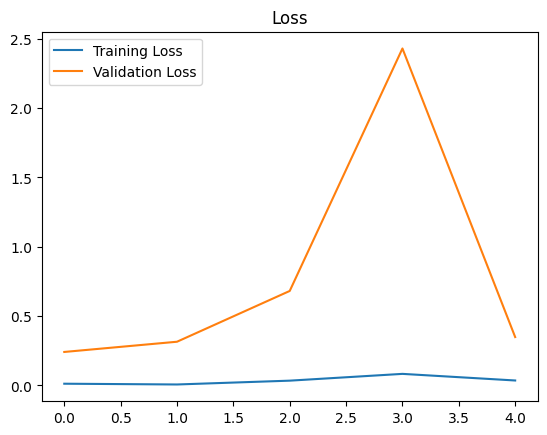

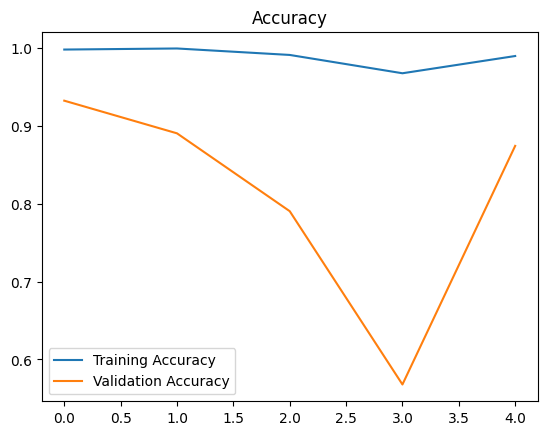

In [48]:
plot_metrics(history) 

# Results

Let's experiment with the best model (the one with the best validation accuracy):

Concretely, the model at the 19th iteration with validation accuracy of 90.65%

### Load the best model

In [35]:
best_model = load_model(filepath='models/cnn-parameters-improvement-23-0.91.model')

In [36]:
best_model.metrics_names

['loss', 'accuracy']

Evaluate the best model on the testing data:

In [37]:
loss, acc = best_model.evaluate(x=X_test, y=y_test)

10/10 [==============================] - 3s 255ms/step - loss: 0.2763 - accuracy: 0.9161


### Accuracy of the best model on the testing data:

In [38]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")

Test Loss = 0.2763063609600067
Test Accuracy = 0.9161290526390076


### F1 score for the best model on the testing data:

In [39]:
y_test_prob = best_model.predict(X_test)

10/10 [==============================] - 3s 250ms/step


In [40]:
f1score = compute_f1_score(y_test, y_test_prob)
print(f"F1 score: {f1score}")

F1 score: 0.9150326797385621


Let's also find the f1 score on the validation data:

In [41]:
y_val_prob = best_model.predict(X_val)

10/10 [==============================] - 3s 303ms/step


In [43]:
f1score_val = compute_f1_score(y_val, y_val_prob)
print(f"F1 score: {f1score_val}")

F1 score: 0.9051987767584098


### Results Interpretation

Let's remember the percentage of positive and negative examples:

In [44]:
def data_percentage(y):
    
    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive
    
    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {n_positive}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {n_negative}") 



In [45]:
# the whole data
data_percentage(y)

Number of examples: 2065
Percentage of positive examples: 52.54237288135593%, number of pos examples: 1085
Percentage of negative examples: 47.45762711864407%, number of neg examples: 980


In [46]:
print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)

Training Data:
Number of examples: 1445
Percentage of positive examples: 52.733564013840834%, number of pos examples: 762
Percentage of negative examples: 47.266435986159166%, number of neg examples: 683
Validation Data:
Number of examples: 310
Percentage of positive examples: 54.193548387096776%, number of pos examples: 168
Percentage of negative examples: 45.806451612903224%, number of neg examples: 142
Testing Data:
Number of examples: 310
Percentage of positive examples: 50.0%, number of pos examples: 155
Percentage of negative examples: 50.0%, number of neg examples: 155
